### Environment Config

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

### Download GloVe Word Embeddings
[GloVe](https://nlp.stanford.edu/projects/glove/) word embeddings are vector representation of words. These word embeddings will be used to create vectors for our sentences. We could have also used the Bag-of-Words or TF-IDF approaches to create features for our sentences, but these methods ignore the order of the words (and the number of features is usually pretty large).

We will be using the pre-trained Wikipedia 2014 + Gigaword 5 GloVe vectors available [here](https://nlp.stanford.edu/data/glove.6B.zip). Heads up – the size of these word embeddings is 822 MB.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-05-30 23:19:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-30 23:19:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-30 23:19:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

#### Extract the words embeddings or word vectors.

In [ ]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

len(word_embeddings)

400000

We have word vectors for 400,000 different terms stored in the dictionary – ‘word_embeddings’.

### Read Dataset

Data was preprocessed by other script available in: https://github.com/HWatanuki/Projeto_D3TOP/blob/main/Codigos/Data_preprocessing_v0.2.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/IFSP/Trabalhos_Grupo_IFSP/NLP

/content/drive/MyDrive/Colab Notebooks/IFSP/Trabalhos_Grupo_IFSP/NLP


In [4]:
file_path = 'data/processed/'
file_name = 'dataset_airbnb-processed_2023-04-13_03-28-09-439.csv'
# file_name = 'dataset_airbnb-scraper_2023-04-04_01-45-49-997.csv'

df = pd.read_csv(file_path + file_name, dtype=str)
print(f'No Rows: {df.shape[0]}')
print(f'No Columns: {df.shape[1]}', end='\n\n')
display(df.head())

No Rows: 561
No Columns: 94



,address,isAvailable,isHostedBySuperhost,location/lat,location/lng,numberOfGuests,photos/0/caption,photos/0/pictureUrl,photos/0/thumbnailUrl,pricing/rate/amount,pricing/rate/amountFormatted,pricing/rate/currency,pricing/rate/isMicrosAccuracy,pricing/rateType,primaryHost/badges/0,primaryHost/badges/1,primaryHost/badges/2,primaryHost/firstName,primaryHost/hasInclusionBadge,primaryHost/hasProfilePic,primaryHost/id,primaryHost/isSuperHost,primaryHost/languages/0,primaryHost/listingsCount,primaryHost/memberSince,primaryHost/responseRate,primaryHost/responseTime,primaryHost/smartName,primaryHost/totalListingsCount,reviews/0/author/firstName,reviews/0/author/id,reviews/0/createdAt,reviews/0/id,reviews/0/rating,reviews/1/author/firstName,reviews/1/author/id,reviews/1/createdAt,reviews/1/id,reviews/1/rating,reviews/2/author/firstName,reviews/2/author/id,reviews/2/createdAt,reviews/2/id,reviews/2/rating,reviews/3/author/firstName,reviews/3/author/id,reviews/3/createdAt,reviews/3/id,reviews/3/rating,reviews/4/author/firstName,reviews/4/author/id,reviews/4/createdAt,reviews/4/id,reviews/4/rating,reviews/5/author/firstName,reviews/5/author/id,reviews/5/createdAt,reviews/5/id,reviews/5/rating,reviews/6/author/firstName,reviews/6/author/id,reviews/6/createdAt,reviews/6/id,reviews/6/rating,reviews/7/author/firstName,reviews/7/author/id,reviews/7/createdAt,reviews/7/id,reviews/7/rating,reviews/8/author/firstName,reviews/8/author/id,reviews/8/createdAt,reviews/8/id,reviews/8/rating,reviews/9/author/firstName,reviews/9/author/id,reviews/9/createdAt,reviews/9/id,reviews/9/rating,roomType,stars,url,name,primaryHost/about,reviews/0/comments,reviews/1/comments,reviews/2/comments,reviews/3/comments,reviews/4/comments,reviews/5/comments,reviews/6/comments,reviews/7/comments,reviews/8/comments,reviews/9/comments
0,"Jersey City, New Jersey, United States",true,false,40.7233,-74.03946,2,NaN,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=large,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=small,99999,"$99,999",USD,false,nightly,82 Reviews,Identity verified,NaN,Joes,false,true,245395267,false,中文 (简体),8,Joined in February 2019,NaN,NaN,Joes,14,Miranda,74889676.0,2022-06-20T19:58:54Z,6.536263641559459e+17,4,Abhimanyu,4800160.0,2022-05-23T18:57:26Z,6.333017075212511e+17,5,Robert,162871850.0,2022-05-06T17:28:10Z,6.209355874005248e+17,5,Yu,303996502.0,2022-01-09T21:55:09Z,5.362712073993113e+17,5,Mitesh,253080011.0,2021-12-26T20:27:02Z,5.260799932553211e+17,4.0,Arusha,103758126.0,2021-12-22T21:29:10Z,5.2321216515417446e+17,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire rental unit,4.67,https://www.airbnb.com/rooms/53775685,entire cozy unit mins manhattan,love people feel,great location nice building love parking include,stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout,excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host,airbnb stay great view window comfortable convenient living experience settle great,nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate,customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay,NaN,NaN,NaN,NaN
1,"New York, United States",true,false,40.70641,-74.0092,2,NaN,https://a0.muscache.com/im/pictures/e2388507-1f5f-4000-aa1b-d3b2279e682a.jpg?aki_policy=large,https://a0.muscache.com/im/pictures/e2388507-1f5f-4000-aa1b-d3b2279e682a.jpg?aki_policy=small,10000,"$10,000",USD,false,nightly,1 Review,Identity verified,NaN,Chris,false,true,57586379,false,NaN

### Manipulating data for vector representation

In [5]:
# Join all reviews comments for each announcement record
df_s01 = df.copy()
df_s01['comments'] = df_s01[df_s01.columns[df_s01.columns.str.contains('comments')]].agg(lambda x: ' '.join([str(c) for c in x.values if str(c) != 'nan']), axis=1).T
df_s01.head()

,address,isAvailable,isHostedBySuperhost,location/lat,location/lng,numberOfGuests,photos/0/caption,photos/0/pictureUrl,photos/0/thumbnailUrl,pricing/rate/amount,pricing/rate/amountFormatted,pricing/rate/currency,pricing/rate/isMicrosAccuracy,pricing/rateType,primaryHost/badges/0,primaryHost/badges/1,primaryHost/badges/2,primaryHost/firstName,primaryHost/hasInclusionBadge,primaryHost/hasProfilePic,primaryHost/id,primaryHost/isSuperHost,primaryHost/languages/0,primaryHost/listingsCount,primaryHost/memberSince,primaryHost/responseRate,primaryHost/responseTime,primaryHost/smartName,primaryHost/totalListingsCount,reviews/0/author/firstName,reviews/0/author/id,reviews/0/createdAt,reviews/0/id,reviews/0/rating,reviews/1/author/firstName,reviews/1/author/id,reviews/1/createdAt,reviews/1/id,reviews/1/rating,reviews/2/author/firstName,reviews/2/author/id,reviews/2/createdAt,reviews/2/id,reviews/2/rating,reviews/3/author/firstName,reviews/3/author/id,reviews/3/createdAt,reviews/3/id,reviews/3/rating,reviews/4/author/firstName,reviews/4/author/id,reviews/4/createdAt,reviews/4/id,reviews/4/rating,reviews/5/author/firstName,reviews/5/author/id,reviews/5/createdAt,reviews/5/id,reviews/5/rating,reviews/6/author/firstName,reviews/6/author/id,reviews/6/createdAt,reviews/6/id,reviews/6/rating,reviews/7/author/firstName,reviews/7/author/id,reviews/7/createdAt,reviews/7/id,reviews/7/rating,reviews/8/author/firstName,reviews/8/author/id,reviews/8/createdAt,reviews/8/id,reviews/8/rating,reviews/9/author/firstName,reviews/9/author/id,reviews/9/createdAt,reviews/9/id,reviews/9/rating,roomType,stars,url,name,primaryHost/about,reviews/0/comments,reviews/1/comments,reviews/2/comments,reviews/3/comments,reviews/4/comments,reviews/5/comments,reviews/6/comments,reviews/7/comments,reviews/8/comments,reviews/9/comments,comments
0,"Jersey City, New Jersey, United States",true,false,40.7233,-74.03946,2,NaN,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=large,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=small,99999,"$99,999",USD,false,nightly,82 Reviews,Identity verified,NaN,Joes,false,true,245395267,false,中文 (简体),8,Joined in February 2019,NaN,NaN,Joes,14,Miranda,74889676.0,2022-06-20T19:58:54Z,6.536263641559459e+17,4,Abhimanyu,4800160.0,2022-05-23T18:57:26Z,6.333017075212511e+17,5,Robert,162871850.0,2022-05-06T17:28:10Z,6.209355874005248e+17,5,Yu,303996502.0,2022-01-09T21:55:09Z,5.362712073993113e+17,5,Mitesh,253080011.0,2021-12-26T20:27:02Z,5.260799932553211e+17,4.0,Arusha,103758126.0,2021-12-22T21:29:10Z,5.2321216515417446e+17,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire rental unit,4.67,https://www.airbnb.com/rooms/53775685,entire cozy unit mins manhattan,love people feel,great location nice building love parking include,stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout,excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host,airbnb stay great view window comfortable convenient living experience settle great,nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate,customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay,NaN,NaN,NaN,NaN,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable conveni

In [ ]:
# Select just some interesting columns
df_s02 = df_s01[['address', 'numberOfGuests', 'name', 'pricing/rate/amount', 'roomType', 'comments']].copy()
df_s02

,address,numberOfGuests,name,pricing/rate/amount,roomType,comments
0,"Jersey City, New Jersey, United States",2,entire cozy unit mins manhattan,99999,Entire rental unit,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable convenient living experience settle great nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay
1,"New York, United States",2,lux studio wall street heart fidi,10000,Entire rental unit,place perfect month stay clean organize location convenient close supermarket pharmacy restaurants chris wonderful host extremely attentive easy communicate book
2,"New York, United States",12,studio double queen refinery hotel,1639,Entire serviced apartment,
3,"East Orange, New Jersey, United States",16,nyc filming weddings retreat,1801,Entire condo,
4,"Passaic, New Jersey, United States",16,artists loaf,2500,Entire loft,
...,...,...,...,...,...,...
556,"New York, United States",4,midtown br elevator doorman nr,399,Entire rental unit,
557,"New York, United States",2,king bed suite central park,391,Room in hotel,great place stay great night stay location great room clean perfect enjoy place good place stay great location
558,"New York, United States",4,sutton place br gym pool dm nr central pk,431,Entire rental unit,
559,"New York, United States",4,sunny east village loft,419,Entire loft,great place great location great host peaceful comfortable colorful fun phillip recommendations perfect notice local places point true feel neighborhood daughter neighborhood let enjoy gem place phillip wonderful host super responsive document extremely helpful check explore area apartment charming wonderful location absolutely love interior design decorations love stay amazing apartment guest location great iron city york ventilation improve cook share amazing place feel yorker extremely clean fun decor loft pull bed comfortable comfortable place great location place clean host extremely communicative stay great location address list actual airbnb listing booking document philip send separately apartment floor nice advance case disability older guests clean neat cleaning crew prior stay forget remove food previous guests refrigerator philip wonderful host terrific communicator place fabulous layout decor super comfy sofa bed stay terrace perfect stay philip lot thought create space location incredible surely stay future fantastic nyc apartment large balcony overlook street noisy plenty natural light great location phillip include plenty recommendation feel locals great location good bed tasteful apartment busy area quiet place peaceful getaway manhattan philipp commit host need


### Vector Representation of Sentences in columns `comments`

In [ ]:
comment_id = 496
sentences = df_s02['comments'].iloc[comment_id].split('  ')
sentence_vectors = []
for i in sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sentence_vectors[:3]

[array([ 0.02246014,  0.24159975,  0.15256001,  0.02144441,  0.04893422,
         0.23178481, -0.28749731,  0.36314405, -0.05309126, -0.01124537,
         0.04791138, -0.12440256,  0.15622345, -0.08932914,  0.05461508,
        -0.14577179,  0.0278677 ,  0.10546105, -0.34166412,  0.23018181,
         0.20796672,  0.26798329,  0.01145381, -0.44279503, -0.04440032,
        -0.10157296, -0.07124487, -0.28275017, -0.17414896, -0.07819327,
        -0.2157473 ,  0.21340543,  0.05415697,  0.09780058,  0.28471932,
         0.42168791, -0.0607991 ,  0.09958948,  0.10631166, -0.2155577 ,
         0.17845829, -0.22564328,  0.11485067, -0.33021403,  0.23046004,
         0.17049463,  0.02369283, -0.02503518,  0.29621516, -0.39558476,
        -0.02091952, -0.13666123, -0.03067406,  0.54872555, -0.09488213,
        -1.72448597,  0.08875228,  0.0130519 ,  1.1552471 ,  0.02802703,
        -0.33863858,  0.50581928, -0.08482098, -0.03036119,  0.48188841,
         0.02198915,  0.29582999, -0.07433586,  0.1

### Similarity Matrix Preparation

using the cosine similarity approach

In [ ]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [ ]:
# initialize the matrix with cosine similarity scores.

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

convert the similarity matrix `sim_mat` into a graph. The nodes of this graph will represent the sentences and the edges will represent the similarity scores between the sentences. 

In [ ]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

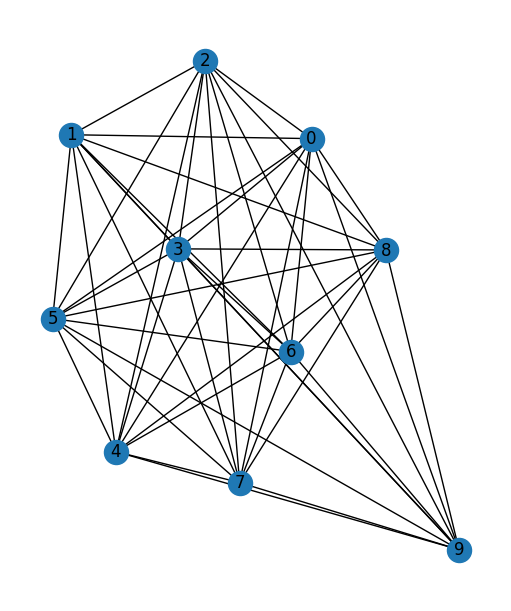

In [ ]:
fig, ax = plt.subplots(figsize=(5,6), layout='constrained')
nx.draw(nx_graph, with_labels=True)
plt.show()

### Summary Extraction

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
n_range = 5 if len(sentences) >= 5 else 2
for i in range(n_range):
  print(ranked_sentences[i][1])

great stay superb location central subway access nyc offer lots great restaurants coffee shops walking distance quiet safe area apartment homey comfortable amenities need rozaliya fantastic host responsive recommend place love stay nyc
terms location rozaliyas flat grand central minutes walk rockefeller center choice restaurants breakfast places contact super friendly helpful amenities flat great comfy couch sleep comfy bed big tvs dining table complain noise level york noisy windows sound european standards nights short earplugs quiet evening happy central location explore manhattan moneys worth
perfect stay rozaliya appartement warm quality bed lot space cook close shops buy food good location nyc nyc rozaliya apartment
amazing time alex rozaliya place apartment spacious clean need month stay comfiest couch huge tvs fully equip kitchen locate blocks grand central alex rozaliya responsive questions stay open recommend
perfect apartment great location blocks clean comfortable


In [ ]:
sentences[:10]

['great stay superb location central subway access nyc offer lots great restaurants coffee shops walking distance quiet safe area apartment homey comfortable amenities need rozaliya fantastic host responsive recommend place love stay nyc',
 'experience airbnb rozaliya family nice welcoming set arrival recommend',
 'terrific stay great location plenty space rozaliya helpful accommodating',
 'terms location rozaliyas flat grand central minutes walk rockefeller center choice restaurants breakfast places contact super friendly helpful amenities flat great comfy couch sleep comfy bed big tvs dining table complain noise level york noisy windows sound european standards nights short earplugs quiet evening happy central location explore manhattan moneys worth',
 'rozaliyas apartment lovely spacious wellequipped need kitchenware towels tv internet blow dryer bed couch soft comfortable apartment prewar building locate centrally nyc access grocery stores subway restaurants deli pharmacy rozaliya 



---



---

## Outra tentativa

---


In [ ]:
# Join all reviews comments for each announcement record
df_s01 = df.copy()
df_s01['comments'] = df_s01[df_s01.columns[df_s01.columns.str.contains('comments')]].agg(lambda x: ' '.join([str(c) for c in x.values if str(c) != 'nan']), axis=1).T

In [6]:
df_s02 = df_s01[['address', 'numberOfGuests', 'name', 'pricing/rate/amount', 'roomType', 'comments']].copy()
df_s02.sample(1)

,address,numberOfGuests,name,pricing/rate/amount,roomType,comments
369,"New York, United States",5,bedrooms entire apartment downtown manhattan,500,Entire rental unit,price stay location space tons restaurants bars chinatown bowery tang amazing host quick respond easy coordinate highly recommend groups multiple rooms prioritize proximity place stay month apartment size good compare ny standards host amazing communication place accommodating provide spices toilet paper plates pans soap close metro lines place convenient want upper parts manhattan brooklyn close nice places eat chinatown italy kitchen living room size nice want cook watch tv living room smart tv netflix log rooms nice personally monitor work majorr room nice dresser store clothes room perks bathroom sink leaky host kind ve love body mirror apartment mirrors fit checks room ac summer nice interesting building central heat wasn problem initial lock building door good security measures honestly couldn think place live host month nyc easy host feel want experience kwan place great cohost time free cereal yogurt coffee tea additional food drink items offer purchase location great walking brooklyn bridge min battery park italy chinatown close subway bus stops stay time ny tangs place great location locate chinatown awesome places eat shop groceries coffee tea milk tea float boat walking distance bit timesquare main attractions nearby close battery park ellis island statue liberty cruise brooklyn bridge rundown estimate time places apartment met minutes combo walk metro metro ride walk mettimesquare minutes combo walking ride metro empire minutes combo walking ride metro rock observatory minutes combo walk ride metro battery park min walk min drive brooklyn bridge min walk bridge chinese bakeries asian food desserts etcpretty arounddont eat grocery stores min walk cook apartmentthis place clean bed neat spacious firm love firm beds EMOJI sorri tang kwan responsive stay reply super accomodatingi recommend place stay kwan clean space quiet comfortable great location chinatown enjoy city keurig coffees appreciate amenity careful good timethe room comfortablethank muchit fun trip clean modest room amenities need cute place great hosts quick respond convenient location room nice cozy stay amazing clear instructions checkin hard time open door unit lol didnt expect area chinese community bit afraid ncov offense tangs place good coz extremely clean room beautiful great location nice space


#### TF-IDF Vectoriser

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from random import randint
import math

In [8]:
max_words = 10000
vectoriser = TfidfVectorizer(max_features=max_words)
tfidf_result = vectoriser.fit_transform(df_s02['comments'])
print(f'Data Transformed.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Data Transformed.
No. of feature_words:  6779


#### TF-IDF Scores

In [9]:
feature_names = vectoriser.get_feature_names_out()
print(f'TDM contains {len(feature_names)} terms and {tfidf_result.shape[0]} documents')

print(f'first term: {feature_names[0]}')
print (f'last term: {feature_names[len(feature_names) - 1]}')

for i in range(0, 4):
    print(f'random term: {feature_names[randint(1,len(feature_names) - 2)]}')

TDM contains 6779 terms and 561 documents
first term: aand
last term: zwei
random term: ins
random term: display
random term: zehra
random term: log


In [10]:
# selecting a random record
comment_id = randint(0, tfidf_result.shape[0] - 1)
# comment_id = 496
print('Comment index selected: ', comment_id)

comment_text = df_s02['comments'].iloc[comment_id]
df_s02.iloc[comment_id].to_frame().T

Comment index selected:  387


,address,numberOfGuests,name,pricing/rate/amount,roomType,comments
387,"Brooklyn, New York, United States",2,bohemian style duplex garden,495,Entire rental unit,paolo place great private outdoor space tons plants comfortable bed good vibes stay walkable places higher rent areas book save money trip neighborhood feel sketch fantastic location beautiful clean space responsive helpful host pleasure stay paolos hope airbnb book great super cozy vibes great peaceful serene energy entire space late traffic meet positive attitude paolo place welcoming decor amazing great communicator backyard perfect wait amazing time paolo super communicative place great fabulous stay paolo place perfect paolo place fantastic eclectic chic spacious comfortable friendly fast respond messages great place stay absolutely impeccable apartment great location amazing win regret book paola stay


iterate through the comment (all reviews together), calculating a score for each sentence by summing the TF-IDF values for each word appearing in the sentence. We normalize the sentence scores by dividing by the number of tokens in the sentence (to avoid bias in favor of longer sentences). Then we sort the sentences by their scores, and return the highest-scoring sentences as our summary. The number of sentences returned corresponds to roughly 20% of the overall length of the comment.

In [ ]:
sent_scores = []
for sentence in comment_text.split('  '):
  # print(sentence)
  score = 0
  sent_tokens = sentence.split()
  for token in (t for t in sent_tokens if t in feature_names):
      score += tfidf_result[comment_id, np.squeeze(np.where(feature_names == token))]      
  sent_scores.append((score / len(sent_tokens), sentence))

summary_length = int(math.ceil(len(sent_scores) / 5))
sent_scores.sort(key=lambda sent: sent[0])

print('*** SUMMARY ***')
for summary_sentence in sent_scores[:summary_length]:
    print(summary_sentence[1])

print('\n*** ORIGINAL ***')
print(comment_text)

*** SUMMARY ***
stylish space bright sunny comfortable couples single note downstairs bathroom isn hall bath attach bedroom fine family guy desk help unit great ve figure key card
ideal place stay clean quiet midst midtown

*** ORIGINAL ***
apartment light equip view amazing location perfect broadway subway lines ricardo alejandra easy chat accommodate demands experience issues building elevator fix perfect  pros great location great host cons furnishings attention  wonderful homeawayfromhome experience group perfect space relax unwind werent galavant york location quiet peaceful night experience stay ny regular hotel meals apartment feel stay comfortable loung living room sit kitchen table sip wine laugh chat days events location central plans theatre district visit central park rockefeller center walk need amazing restaurant butter door perfect place dine night connect lobby didnt lug coats order delicious differently stay be to pack sleep mask block bit light sleep group absolutely 